### 1. Carga y Visualización de Imágenes DICOM


Mostrando imagen aleatoria con ID: f8bbdcf948609aea0b384583364379e5 y Study ID: 44547b977313c66f106c07f99e492ee2
ROI #489: ['Suspicious Calcification'], BIRADS: BI-RADS 4
ROI #490: ['Suspicious Calcification'], BIRADS: BI-RADS 4
ROI #491: ['Suspicious Calcification'], BIRADS: BI-RADS 4

Metadatos asociados a la imagen:
Photometric Interpretation: MONOCHROME2
Window Center & Width Explanation: linear LUT


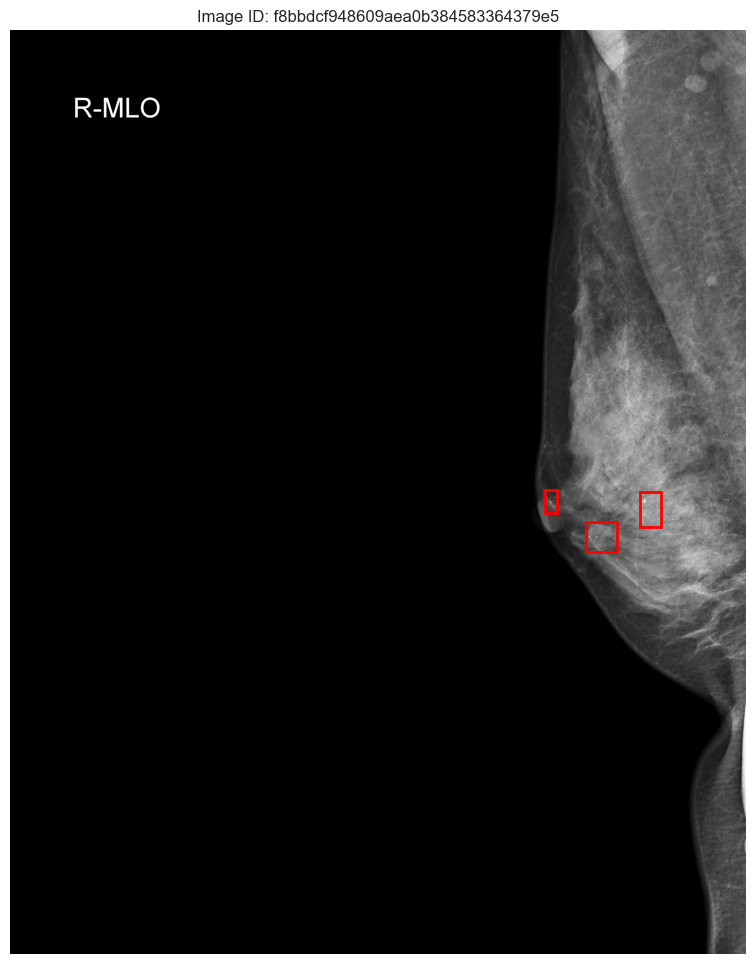

In [53]:
import os
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pydicom.pixel_data_handlers.util import apply_voi_lut
import ast

# Ruta al dataset DICOM
dicom_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/images'

# Ruta a los CSV de anotaciones y metadatos
annotations_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/finding_annotations.csv'
metadata_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/metadata.csv'

# Cargar las anotaciones y el archivo de metadatos
findings = pd.read_csv(annotations_csv)
metadata = pd.read_csv(metadata_csv)

# Convertir la columna 'finding_categories' a listas (si es que están como cadenas)
findings['finding_categories'] = findings['finding_categories'].apply(ast.literal_eval)

# Función para obtener la ruta del archivo DICOM dado el image_id y study_id
def get_dicom_path(image_id, study_id, root_dir):
    return os.path.join(root_dir, study_id, image_id + '.dicom')

# Función para leer el archivo DICOM y aplicar VOI LUT (si está disponible)
def read_dicom_image(image_id, study_id):
    dicom_path = get_dicom_path(image_id, study_id, dicom_root)
    dicom = pydicom.dcmread(dicom_path)
    # Aplicar VOI LUT para ajustar la imagen según el dicom
    image = apply_voi_lut(dicom.pixel_array, dicom)
    return dicom, image

# Función para dibujar las cajas delimitadoras en la imagen
def draw_bounding_boxes(ax, image_id):
    # Obtener anotaciones para la imagen
    image_annotations = findings[findings['image_id'] == image_id]
    
    for idx, row in image_annotations.iterrows():
        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        width, height = xmax - xmin, ymax - ymin
        
        # Dibujar la caja delimitadora
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Mostrar información de la ROI (opcional)
        print(f"ROI #{idx+1}: {row['finding_categories']}, BIRADS: {row['breast_birads']}")

# Función para filtrar imágenes que NO tengan "No Finding"
def filter_images_with_findings():
    # Filtrar imágenes que no contengan "No Finding" en la lista de categories
    findings_with_finding = findings[findings['finding_categories'].apply(lambda x: 'No Finding' not in x)]
    return findings_with_finding

# Función para asociar el image_id de findings con SOP Instance UID de metadata
def get_metadata_info(image_id):
    # Buscar la imagen correspondiente en el metadata usando el SOP Instance UID
    metadata_info = metadata[metadata['SOP Instance UID'] == image_id]
    if not metadata_info.empty:
        # Extraer la información de las columnas relevantes
        photometric_interpretation = metadata_info['Photometric Interpretation'].values[0]
        window_center_width_explanation = metadata_info['Window Center & Width Explanation'].values[0]
        return photometric_interpretation, window_center_width_explanation
    else:
        return None, None

# Función para mostrar una imagen DICOM aleatoria en alta resolución con ROI y metadatos
def show_random_dicom_with_roi_and_metadata():
    # Filtrar las filas que NO tengan 'No Finding'
    findings_with_finding = filter_images_with_findings()
    
    if findings_with_finding.empty:
        print("No se encontraron imágenes con findings.")
        return
    
    # Seleccionar una fila aleatoria del dataset filtrado
    random_row = findings_with_finding.sample(n=1).iloc[0]
    
    # Obtener el image_id y study_id de la imagen seleccionada
    image_id = random_row['image_id']
    study_id = random_row['study_id']
    
    print(f"Mostrando imagen aleatoria con ID: {image_id} y Study ID: {study_id}")
    
    # Leer la imagen DICOM
    dicom, image = read_dicom_image(image_id, study_id)
    
    # Mostrar la imagen a alta resolución
    fig, ax = plt.subplots(figsize=(12, 12))  # Tamaño más grande para alta resolución
    ax.imshow(image, cmap='gray')
    
    # Dibujar las cajas delimitadoras en la imagen
    draw_bounding_boxes(ax, image_id)
    
    # Obtener información de metadatos del CSV 'metadata.csv'
    photometric_interpretation, window_center_width_explanation = get_metadata_info(image_id)
    
    if photometric_interpretation and window_center_width_explanation:
        print(f"\nMetadatos asociados a la imagen:")
        print(f"Photometric Interpretation: {photometric_interpretation}")
        print(f"Window Center & Width Explanation: {window_center_width_explanation}")
    else:
        print("\nNo se encontraron metadatos para esta imagen.")
    
    ax.set_title(f"Image ID: {image_id}")
    ax.axis('off')  # Ocultar los ejes para mejor visualización
    plt.show()

# Mostrar una imagen DICOM aleatoria con su ROI y metadatos
show_random_dicom_with_roi_and_metadata()


Podemos observar una imágen con 3 anotaciones, calcificaciones específicamente.

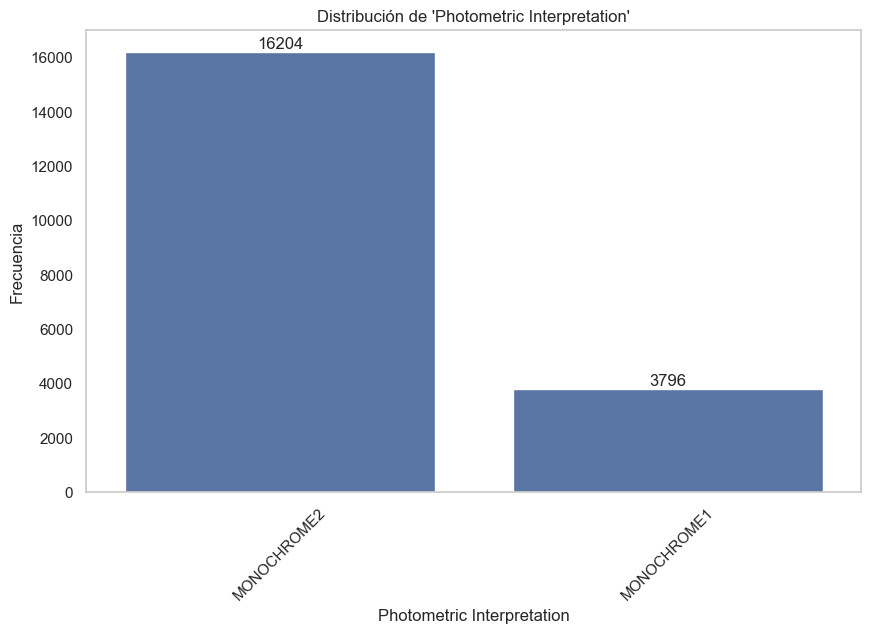


Conteo de categorías en 'Photometric Interpretation':
Photometric Interpretation
MONOCHROME2    16204
MONOCHROME1     3796
Name: count, dtype: int64


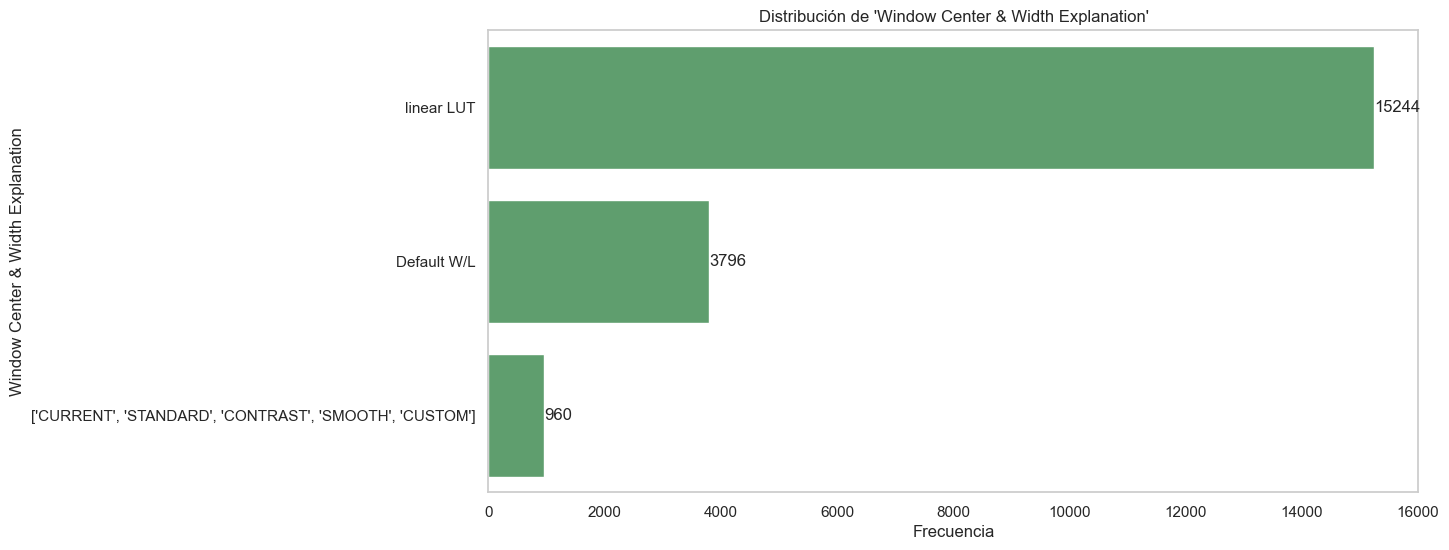


Conteo de categorías en 'Window Center & Width Explanation':
Window Center & Width Explanation
linear LUT                                                 15244
Default W/L                                                 3796
['CURRENT', 'STANDARD', 'CONTRAST', 'SMOOTH', 'CUSTOM']      960
Name: count, dtype: int64


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo para las gráficas
sns.set(style="whitegrid")

# Ruta al CSV de metadatos
metadata_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/metadata.csv'

# Cargar el archivo de metadatos
metadata = pd.read_csv(metadata_csv)

# 1. Gráfico de frecuencia de 'Photometric Interpretation' con conteo
def plot_photometric_interpretation_distribution():
    plt.figure(figsize=(10, 6))
    sns.countplot(data=metadata, x='Photometric Interpretation', color='b')  # Eliminamos 'palette' y asignamos un color único
    
    # Agregar conteo encima de cada barra
    photometric_counts = metadata['Photometric Interpretation'].value_counts()
    for i, count in enumerate(photometric_counts):
        plt.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=12)

    plt.title("Distribución de 'Photometric Interpretation'")
    plt.xlabel("Photometric Interpretation")
    plt.ylabel("Frecuencia")
    plt.grid(False)
    plt.xticks(rotation=45)  # Rotar etiquetas si son largas
    plt.show()

    # Mostrar el conteo de cada categoría en la consola
    print("\nConteo de categorías en 'Photometric Interpretation':")
    print(photometric_counts)

# 2. Gráfico de frecuencia de 'Window Center & Width Explanation' con conteo
def plot_window_center_width_explanation_distribution():
    plt.figure(figsize=(12, 6))
    sns.countplot(data=metadata, y='Window Center & Width Explanation', color='g')  # Eliminamos 'palette' y asignamos un color único
    
    # Agregar conteo encima de cada barra
    window_counts = metadata['Window Center & Width Explanation'].value_counts()
    for i, count in enumerate(window_counts):
        plt.text(count + 1, i, str(count), va='center', fontsize=12)

    plt.title("Distribución de 'Window Center & Width Explanation'")
    plt.xlabel("Frecuencia")
    plt.ylabel("Window Center & Width Explanation")
    plt.grid(False)
    plt.show()

    # Mostrar el conteo de cada categoría en la consola
    print("\nConteo de categorías en 'Window Center & Width Explanation':")
    print(window_counts)

# Ejecutar las funciones para visualizar los gráficos de frecuencia con conteo
plot_photometric_interpretation_distribution()
plot_window_center_width_explanation_distribution()


## Photometric Interpretation en Imágenes DICOM

**Photometric Interpretation** es un atributo dentro del formato DICOM (Digital Imaging and Communications in Medicine) que describe cómo deben interpretarse los valores de los píxeles en una imagen médica. Es decir, define cómo los valores de los píxeles deben ser mapeados a tonos de gris o color en la visualización de la imagen.

### Tipos comunes de Photometric Interpretation:

#### MONOCHROME1:
- En este modo, los valores de píxeles bajos corresponden a tonos **claros** (blanco) y los valores de píxeles altos corresponden a tonos **oscuros** (negro).
- Es el **inverso** de MONOCHROME2.
- Se usa principalmente cuando los objetos de interés deben aparecer oscuros sobre un fondo claro, como en algunas imágenes de mamografía.

#### MONOCHROME2:
- En este modo, los valores de píxeles bajos corresponden a tonos **oscuros** (negro) y los valores de píxeles altos corresponden a tonos **claros** (blanco).
- Es el modo más común para imágenes médicas en escala de grises, como radiografías y tomografías computarizadas (TC). En estas imágenes, los tejidos más densos, como los huesos, aparecen más claros (valores altos), mientras que el aire o áreas menos densas aparecen más oscuras.

#### RGB:
- Las imágenes con esta interpretación utilizan valores de píxeles para representar colores en el formato **Red-Green-Blue (RGB)**. Cada píxel tiene tres componentes (uno para cada color) y la mezcla de ellos produce la imagen en color.
- Se usa comúnmente en imágenes como fotografías clínicas o endoscopías, donde se necesitan colores reales.

#### PALETTE COLOR:
- Los valores de los píxeles representan índices en una **paleta de colores**. Se utiliza en imágenes donde se aplica una escala de colores específica para representar información, como en algunas imágenes térmicas o imágenes con falsos colores.

#### YBR_FULL, YBR_PARTIAL:
- Estos modos se utilizan para representar imágenes en un formato de color comprimido, principalmente en imágenes de video o imágenes de resonancia magnética.

---

### Ejemplo con MONOCHROME1 y MONOCHROME2:

Imaginemos una imagen en escala de grises:

- Si la imagen tiene un **Photometric Interpretation = MONOCHROME1**, las áreas de menor densidad (con menor valor de píxeles) se verían **blancas**, mientras que las áreas de mayor densidad (con valores de píxeles más altos) se verían **negras**.
- En **MONOCHROME2**, es lo opuesto: las áreas de menor densidad se ven **negras**, y las áreas de mayor densidad se ven **blancas**. Este es el modo de visualización más utilizado en imágenes médicas como radiografías.

---

### ¿Por qué es importante en imágenes médicas?

La **interpretación fotométrica** es fundamental para la correcta visualización y análisis de las imágenes médicas. Dependiendo del tipo de estudio (radiografía, mamografía, tomografía), los médicos deben ver las imágenes con el contraste correcto, de modo que las áreas de interés, como tumores o fracturas, sean claramente visibles.

Por ejemplo, en las mamografías (que generalmente se presentan en **MONOCHROME2**), las densidades más altas, como el tejido mamario más denso, aparecerán más brillantes, lo que permite al radiólogo detectar anomalías como **microcalcificaciones** o **masas**.


## Window Center y Window Width en Imágenes DICOM

**Window Center** (centro de ventana) y **Window Width** (ancho de ventana) son conceptos clave en la visualización de imágenes médicas DICOM, especialmente cuando se trabaja con imágenes en escala de grises, como tomografías computarizadas (TC), resonancias magnéticas (RM) y radiografías.

Estos parámetros controlan cómo se mapean los valores de los píxeles (intensidades) a los niveles de brillo y contraste en una imagen mostrada en un monitor. El ajuste de estos valores permite resaltar diferentes estructuras en las imágenes médicas.

### Window Center (WC):
- El **Window Center** o **nivel de ventana** define el **valor central** alrededor del cual se distribuyen los tonos de gris en la imagen.
- Los píxeles con valores cercanos al **Window Center** aparecerán en tonos medios de gris.
- Los píxeles con valores mucho más altos que el **Window Center** se verán **blancos**, y los píxeles con valores mucho más bajos que el **Window Center** se verán **negros**.
  
**Ejemplo**: Si el **Window Center** está ajustado en 50, los píxeles cuyo valor esté cercano a 50 aparecerán en un tono de gris medio.

### Window Width (WW):
- El **Window Width** o **ancho de ventana** define el **rango de valores de píxeles** que se mapean a los tonos de gris.
- Un **Window Width** más amplio significa que más valores de píxeles se distribuirán a través de una gama de tonos de gris (lo que reduce el contraste).
- Un **Window Width** más estrecho concentrará más valores de píxeles en un rango más pequeño, aumentando el contraste de la imagen.

**Ejemplo**: Si el **Window Width** es 100, se mapearán los valores de píxeles en el rango de `[WC - 50, WC + 50]` a tonos de gris.

### Windowing:
El proceso de ajustar el **Window Center** y el **Window Width** se llama **windowing**. Cambiar estos valores permite al médico ajustar dinámicamente el brillo y el contraste de la imagen para resaltar estructuras específicas.

### Relación entre Window Center y Window Width:
- El **Window Width** controla cuántos tonos de gris se usarán para mostrar la imagen.
- El **Window Center** ajusta qué valor de píxel se considera el nivel medio de gris.

Si tienes una imagen médica donde los huesos son más brillantes que los tejidos blandos, puedes ajustar el **Window Center** y el **Window Width** para resaltar mejor los huesos o para hacer lo contrario y enfocarte en los tejidos blandos.

---

## Window Center & Width Explanation en DICOM

El atributo **Window Center & Width Explanation** en un archivo DICOM describe qué parte de la anatomía o qué tipo de tejido está optimizado con los valores actuales de **Window Center** y **Window Width**.

### Ejemplos de valores típicos en Window Center & Width Explanation:
- **Lung (Pulmones)**: Optimiza la visualización de los tejidos pulmonares.
- **Bone (Huesos)**: Optimiza la visualización de los huesos, que son más densos y aparecerán más brillantes.
- **Brain (Cerebro)**: Optimiza la visualización de los tejidos cerebrales en imágenes de resonancia magnética o tomografía computarizada.

El propósito de esta explicación es ayudar a los radiólogos a entender qué parte de la imagen está optimizada para ser visualizada con los valores de **Window Center** y **Window Width** actuales.

### Ejemplo:
Supongamos que tienes una tomografía computarizada (TC) de tórax y estás revisando el pulmón. Si ajustas los valores de **Window Center** y **Window Width** correctamente para visualizar mejor los pulmones, el **Window Center & Width Explanation** puede tener un valor de **"Lung"** para indicar que estos valores están optimizados para los tejidos pulmonares.

---

## ¿Por qué es importante?

El **Window Center** y **Window Width** son críticos para ajustar el **contraste** y **brillo** en las imágenes médicas, lo que permite a los radiólogos o médicos identificar diferentes tejidos y estructuras con mayor precisión.

**Por ejemplo**:

- Un ajuste más **amplio** del **Window Width** puede ser útil para visualizar toda la gama de tejidos en una tomografía computarizada.
- Un ajuste más **estrecho** se puede usar para observar con mayor detalle una parte específica de la imagen, como un tumor o fractura.


### ¿Qué es VOI LUT?

VOI LUT (Value of Interest Look-Up Table) es una herramienta fundamental en la visualización de imágenes médicas DICOM (Digital Imaging and Communications in Medicine). Permite controlar y ajustar el brillo y el contraste de una imagen para resaltar áreas específicas de interés, optimizando su interpretación.

En las imágenes DICOM, los valores de los píxeles pueden tener un rango muy amplio, que no siempre es fácil de visualizar adecuadamente en un monitor estándar. VOI LUT se utiliza para seleccionar y mapear los valores de píxeles que son clínicamente relevantes (los valores de interés o VOI) a tonos de gris que se pueden visualizar en la pantalla.

Mostrando imagen aleatoria con ID: 4a6d60a3ec7eb3203bef512f48a17387 y Study ID: 3214ca89949d30d5e656433b0a823e29
Aplicando VOI LUT con Window Center: 1665.0, Window Width: 1500.0


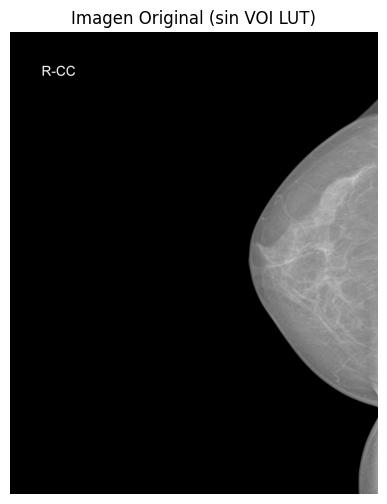

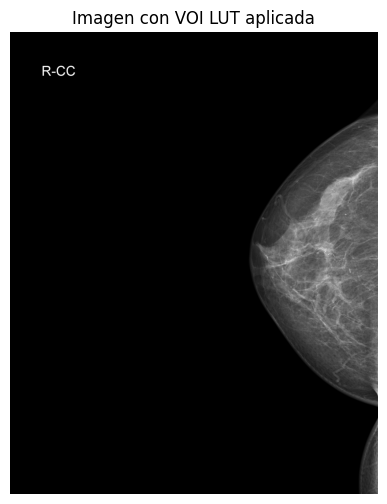

Rango de píxeles después de aplicar VOI LUT: 0 - 3974


In [22]:
import os
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Ruta al dataset DICOM
dicom_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/images'

# Ruta a los CSV de anotaciones y metadatos
annotations_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/finding_annotations.csv'
metadata_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/metadata.csv'

# Cargar las anotaciones y el archivo de metadatos
findings = pd.read_csv(annotations_csv)
metadata = pd.read_csv(metadata_csv)

# Función para obtener la ruta del archivo DICOM dado el image_id y study_id
def get_dicom_path(image_id, study_id, root_dir):
    return os.path.join(root_dir, study_id, image_id + '.dicom')

# Función para leer los valores de VOI desde los metadatos del archivo DICOM
def get_voi_values_from_metadata(image_id):
    # Buscar el row en metadata.csv correspondiente a la imagen
    meta_row = metadata[metadata['SOP Instance UID'] == image_id]
    
    # Si existe el row, extraer los valores de Window Center y Window Width
    if not meta_row.empty:
        window_center = meta_row['Window Center'].values[0]  # Extraer Window Center
        window_width = meta_row['Window Width'].values[0]    # Extraer Window Width
        photometric_interpretation = meta_row['Photometric Interpretation'].values[0]
        return float(window_center), float(window_width), photometric_interpretation
    else:
        return None, None, None

# Función para leer el archivo DICOM, aplicar VOI LUT y visualizar
def read_dicom_and_apply_voi_lut(image_id, study_id):
    dicom_path = get_dicom_path(image_id, study_id, dicom_root)
    dicom = pydicom.dcmread(dicom_path)

    # Aplicar VOI LUT en base a los valores de Window Center y Width
    image = dicom.pixel_array
    
    # Extraer valores de VOI desde los metadatos del archivo DICOM
    window_center, window_width, photometric_interpretation = get_voi_values_from_metadata(image_id)
    
    if window_center is not None and window_width is not None:
        print(f"Aplicando VOI LUT con Window Center: {window_center}, Window Width: {window_width}")
        
        # Aplicar VOI LUT
        voi_image = apply_voi_lut(image, dicom, index=0)
        return dicom, image, voi_image
    else:
        print("No se encontraron valores de VOI LUT en los metadatos.")
        return dicom, image, image  # Retornar la imagen original si no se encuentran valores

# Función para visualizar la imagen con VOI LUT aplicado
def show_dicom_with_proper_voi():
    # Seleccionar una fila aleatoria del dataset
    random_row = findings.sample(n=1).iloc[0]
    
    # Obtener el image_id y study_id de la imagen seleccionada
    image_id = random_row['image_id']
    study_id = random_row['study_id']
    
    print(f"Mostrando imagen aleatoria con ID: {image_id} y Study ID: {study_id}")
    
    # Leer la imagen DICOM y aplicar VOI LUT
    dicom, image, voi_image = read_dicom_and_apply_voi_lut(image_id, study_id)
    
    # Mostrar la imagen original
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title("Imagen Original (sin VOI LUT)")
    plt.axis('off')
    plt.show()
    
    # Mostrar la imagen con VOI LUT aplicado
    plt.figure(figsize=(6, 6))
    plt.imshow(voi_image, cmap='gray')
    plt.title("Imagen con VOI LUT aplicada")
    plt.axis('off')
    plt.show()

    # Mostrar el rango de píxeles
    min_val = np.min(voi_image)
    max_val = np.max(voi_image)
    print(f"Rango de píxeles después de aplicar VOI LUT: {min_val} - {max_val}")

# Ejecutar la función para visualizar la imagen con VOI LUT aplicado correctamente
show_dicom_with_proper_voi()


Nos damos cuenta que el Voi Lut es importante para visualizar mejor las imágenes DICOM 

### Uso de `apply_voi_lut()` en pydicom

En **pydicom**, la función `apply_voi_lut()` ajusta los valores de los píxeles en una imagen DICOM de acuerdo con las configuraciones de ventana (**Window Center** y **Window Width**) o las LUTs (Look-Up Tables) de interés visual (**VOI LUTs**) incluidas en el archivo DICOM.

#### Parámetro `prefer_lut=False`:

El parámetro `prefer_lut` en `apply_voi_lut()` define si se deben usar las **VOI LUTs** en lugar de los parámetros de ventana (**Window Center** y **Window Width**) al ajustar la visualización de la imagen.

- **`prefer_lut=False`**:
  - Con este valor (por defecto), la función **NO** usará las **VOI LUTs** aunque estén presentes en el archivo DICOM.
  - En su lugar, ajustará la imagen utilizando los valores de **Window Center** y **Window Width**.
  - Esto es útil si prefieres que la imagen se ajuste solo mediante los parámetros de ventana para controlar el brillo y el contraste.

- **`prefer_lut=True`**:
  - Si se establece en `True`, la función dará **preferencia a las VOI LUTs** en caso de que estén presentes en el archivo DICOM.
  - Esto significa que, si el archivo contiene una **VOILUTSequence**, los ajustes de la imagen se harán utilizando los datos de esa secuencia de LUTs en lugar de los parámetros de ventana.
  - Esto puede ser útil si quieres utilizar las transformaciones de brillo y contraste específicas definidas por las LUTs en lugar de las definidas por los parámetros de ventana.


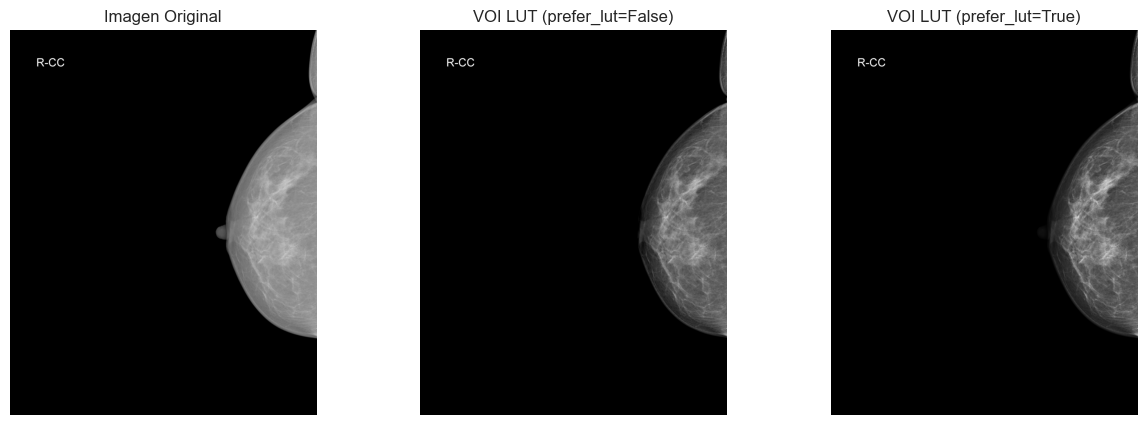

In [28]:
import os
import pydicom
import matplotlib.pyplot as plt
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Ruta al dataset DICOM
dicom_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/images'

# Función para obtener la ruta del archivo DICOM dado el image_id y study_id
def get_dicom_path(image_id, study_id, root_dir):
    return os.path.join(root_dir, study_id, image_id + '.dicom')

# Función para leer el archivo DICOM y aplicar VOI LUT
def visualize_with_and_without_lut(image_id, study_id):
    dicom_path = get_dicom_path(image_id, study_id, dicom_root)
    dicom = pydicom.dcmread(dicom_path)
    
    # Imagen sin aplicar VOI LUT
    original_image = dicom.pixel_array
    
    # Aplicar VOI LUT preferiendo las Window Center & Width
    voi_image_no_lut = apply_voi_lut(original_image, dicom, prefer_lut=False)
    
    # Aplicar VOI LUT preferiendo las LUTs si están presentes
    voi_image_with_lut = apply_voi_lut(original_image, dicom, prefer_lut=True)
    
    # Mostrar las imágenes
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(original_image, cmap='gray')
    axes[0].set_title('Imagen Original')
    axes[0].axis('off')
    
    axes[1].imshow(voi_image_no_lut, cmap='gray')
    axes[1].set_title('VOI LUT (prefer_lut=False)')
    axes[1].axis('off')
    
    axes[2].imshow(voi_image_with_lut, cmap='gray')
    axes[2].set_title('VOI LUT (prefer_lut=True)')
    axes[2].axis('off')
    
    plt.show()

# Ejemplo de uso: seleccionar una imagen aleatoria
import pandas as pd

# Ruta al CSV de anotaciones
annotations_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/finding_annotations.csv'
findings = pd.read_csv(annotations_csv)

# Seleccionar una fila aleatoria del dataset
random_row = findings.sample(n=1).iloc[0]

# Obtener el image_id y study_id de la imagen seleccionada
image_id = random_row['image_id']
study_id = random_row['study_id']

# Visualizar la imagen con y sin VOI LUT
visualize_with_and_without_lut(image_id, study_id)


### Vamos a ver cuántas imágenes vienen con el parámetro VOILUT

In [30]:
import os
import pydicom
import pandas as pd

# Ruta al dataset DICOM
dicom_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/images'

# Función para obtener la ruta del archivo DICOM dado el image_id y study_id
def get_dicom_path(image_id, study_id, root_dir):
    return os.path.join(root_dir, study_id, image_id + '.dicom')

# Función para verificar si un archivo DICOM tiene VOILUTSequence
def has_voilut(dicom):
    # Verificar si el DICOM contiene VOI LUT Sequence
    return hasattr(dicom, 'VOILUTSequence')

# Función para contar cuántas imágenes tienen VOILUTSequence
def count_images_with_voilut(findings):
    images_with_voilut = 0
    images_without_voilut = 0
    
    for idx, row in findings.iterrows():
        image_id = row['image_id']
        study_id = row['study_id']
        dicom_path = get_dicom_path(image_id, study_id, dicom_root)
        
        try:
            dicom = pydicom.dcmread(dicom_path)
            if has_voilut(dicom):
                images_with_voilut += 1
            else:
                images_without_voilut += 1
        except Exception as e:
            print(f"Error leyendo la imagen {image_id}: {str(e)}")
    
    return images_with_voilut, images_without_voilut

# Cargar el archivo CSV de anotaciones
annotations_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/finding_annotations.csv'
findings = pd.read_csv(annotations_csv)

# Contar imágenes con y sin VOI LUT
images_with_voilut, images_without_voilut = count_images_with_voilut(findings)

# Mostrar resultados
print(f"Imágenes con VOI LUT: {images_with_voilut}")
print(f"Imágenes sin VOI LUT: {images_without_voilut}")


Imágenes con VOI LUT: 15475
Imágenes sin VOI LUT: 5011


### Análizamos si es que no tienen VOI LUT , si tienen WC y WW

In [31]:
import os
import pydicom
import pandas as pd

# Ruta al dataset DICOM
dicom_root = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/images'

# Función para obtener la ruta del archivo DICOM dado el image_id y study_id
def get_dicom_path(image_id, study_id, root_dir):
    return os.path.join(root_dir, study_id, image_id + '.dicom')

# Función para verificar si un archivo DICOM tiene VOILUTSequence
def has_voilut(dicom):
    return hasattr(dicom, 'VOILUTSequence')

# Función para verificar si un archivo DICOM tiene Window Center y Window Width
def has_windowing(dicom):
    has_wc = hasattr(dicom, 'WindowCenter')
    has_ww = hasattr(dicom, 'WindowWidth')
    return has_wc, has_ww

# Función para filtrar imágenes sin VOILUT y verificar otros atributos
def filter_images_without_voilut_and_check_windowing(findings):
    images_without_voilut_with_windowing = []
    images_without_voilut_without_windowing = []
    
    for idx, row in findings.iterrows():
        image_id = row['image_id']
        study_id = row['study_id']
        dicom_path = get_dicom_path(image_id, study_id, dicom_root)
        
        try:
            dicom = pydicom.dcmread(dicom_path)
            if not has_voilut(dicom):
                has_wc, has_ww = has_windowing(dicom)
                if has_wc and has_ww:
                    images_without_voilut_with_windowing.append(image_id)
                else:
                    images_without_voilut_without_windowing.append(image_id)
        except Exception as e:
            print(f"Error leyendo la imagen {image_id}: {str(e)}")
    
    return images_without_voilut_with_windowing, images_without_voilut_without_windowing

# Cargar el archivo CSV de anotaciones
annotations_csv = '/Volumes/m2/Memoria/Code/PMM/VinDr-Mammo-Preprocessing/data/original/Vindrmammo/finding_annotations.csv'
findings = pd.read_csv(annotations_csv)

# Filtrar imágenes sin VOI LUT y verificar si tienen Window Center y Window Width
images_with_windowing, images_without_windowing = filter_images_without_voilut_and_check_windowing(findings)

# Mostrar resultados
print(f"Imágenes sin VOI LUT pero con Window Center & Width: {len(images_with_windowing)}")
print(f"Imágenes sin VOI LUT ni Window Center & Width: {len(images_without_windowing)}")

print("Ejemplos de imágenes con Window Center & Width:", images_with_windowing[:5])
print("Ejemplos de imágenes sin Window Center & Width:", images_without_windowing[:5])


Imágenes sin VOI LUT pero con Window Center & Width: 5011
Imágenes sin VOI LUT ni Window Center & Width: 0
Ejemplos de imágenes con Window Center & Width: ['7e2ac68b81c14f458e7323f2f8951cf2', '7e2ac68b81c14f458e7323f2f8951cf2', '6334ea4f303af58784d84f399dae396c', '6334ea4f303af58784d84f399dae396c', '86176a5feecb57e582b70cfb87699929']
Ejemplos de imágenes sin Window Center & Width: []


### Total de imágenes sin VOI LUT: 5,011 imágenes.

Esto significa que hay 5,011 imágenes en el dataset que no contienen la secuencia **VOI LUT** en sus metadatos.  
**VOI LUT (Look-Up Table)** es una secuencia opcional en los archivos DICOM que transforma los valores de los píxeles para mejorar la visualización de las áreas de interés, ajustando brillo y contraste automáticamente. Si no está presente, es necesario utilizar otros métodos, como los valores de **Window Center** y **Window Width**.

---

### Total de imágenes sin VOI LUT pero con valores de Window Center & Width: 5,011 imágenes.

Todas las imágenes que no tienen **VOI LUT** cuentan con valores de **Window Center (WC)** y **Window Width (WW)** en los metadatos (ya sea dentro del archivo DICOM o en el archivo `metadata.csv`).  
**Window Center (WC)** y **Window Width (WW)** son parámetros estándar que permiten ajustar el brillo y el contraste de la imagen mediante ventaneo. Estos valores son fundamentales en la visualización de imágenes médicas, ya que permiten resaltar diferentes estructuras anatómicas ajustando el rango de intensidades visualizadas.

---

### Imágenes sin VOI LUT ni Window Center & Width: 0 imágenes.

No hay imágenes en el dataset que carezcan tanto de **VOI LUT** como de los valores de **Window Center** y **Window Width**.  
Esto es positivo, ya que garantiza que cada imagen en el dataset tiene una forma definida para ajustar el contraste y brillo, ya sea utilizando **VOI LUT** o ventaneo estándar mediante **WC/WW**.

---

### Implicaciones:

- **Visualización fiable**: Dado que todas las imágenes que no tienen **VOI LUT** contienen **Window Center** y **Window Width**, siempre es posible ajustar correctamente la visualización de las imágenes en términos de brillo y contraste.
- **Ajuste predeterminado**: Si no hay **VOI LUT**, el ajuste de las imágenes debe realizarse utilizando **Window Center** y **Window Width**, que proporcionan una alternativa estándar para visualizar las imágenes correctamente.
- **Mejora en el flujo de trabajo**: No es necesario preocuparse por imágenes que carezcan de datos para ajustar la visualización, ya que cada imagen tiene los atributos necesarios, lo que permite una visualización consistente en todo el dataset.
